In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
def testscore(predtmp,oritmp):
    score=1
    pred=np.ravel(predtmp)
    ori=np.ravel(oritmp)
    if(len(pred)!=len(ori)):
        print('len not match')
        return 1
    n=0
    for i in range(len(pred)):
        if ori[i]!=0:
            n=n+1
    #print(n)
    for i in range(len(pred)):
        if ori[i]!=0:
            score=score-1/n*abs(pred[i]-ori[i])/abs(ori[i])/2
            #print(abs(pred[i]-ori[i])/abs(ori[i]))
    print('score:')
    print(score)
    return score

In [3]:

file_path = os.path.join('D:\\', 'hotaidata','sr_C4_12')
x=[]
y=[]
vx=[]
vy=[]
isvalid=[]
xtmp=[]
ytmp=[]
vxtmp=[]
vytmp=[]
isvalidtmp=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00001.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp.append(float(num[0]))
                    ytmp.append(float(num[1]))
                    vxtmp.append(float(num[2]))
                    vytmp.append(float(num[3]))
                    isvalidtmp.append(float(num[4]))

            x.append(np.array(xtmp).reshape(25,25))
            y.append(np.array(ytmp).reshape(25,25))
            vx.append(np.array(vxtmp).reshape(25,25))
            vy.append(np.array(vytmp).reshape(25,25))
            isvalid.append(np.array(isvalidtmp).reshape(25,25))
            xtmp=[]
            ytmp=[]
            vxtmp=[]
            vytmp=[]
            isvalidtmp=[]
#
x=np.array(x)
y=np.array(y)
vx=np.array(vx)
vy=np.array(vy)
isvalid=np.array(isvalid)

x=x.T
y=y.T
vx=vx.T
vy=vy.T
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=0.00002

t=t[90:120]
print(len(t))
t_train=np.linspace(t[0],t[-1],len(t)*3-2)
dt_train=t_train[1]-t_train[0]
print(t_train.shape)

30
(88,)


In [4]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=25

u=np.zeros((n,n,121, 2))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u_train=np.zeros((n,n,len(t), 2))

u_train=u[:,:,90:120,:]

v_train=np.zeros((n,n,len(t_train),2))

for i in range(len(t)-1):
    v_train[:,:,3*i]=u_train[:,:,i]
    v_train[:,:,3*i+1]=(u_train[:,:,i]*2+u_train[:,:,i+1])/3
    v_train[:,:,3*i+2]=(u_train[:,:,i]+u_train[:,:,i+1]*2)/3
v_train[:,:,-1]=u_train[:,:,-1]


In [5]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)

vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
testscore(vtmp,v_train)
vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
testscore(vtmp,v_train)

score:
0.47385139473915
score:
0.8252381181183647


0.8252381181183647

In [6]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.
library_functions = [
    lambda y: y,
    lambda x: x * x * x,

    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda y: y,
    lambda x: x + x + x,

    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)


# Again, loop through all the optimizers
#print('STLSQ model: ')
print('v_train')
print(v_train.shape)

'''
print('SINDy')
model = ps.SINDy(feature_names=['Vx','Vy'])

model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_train)

'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(v_train, dt_train)
model.print()
'''
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, t=dt)
model.print()


print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()'''

v_train
(25, 25, 88, 2)
STLSQ model: 
(Vx)' = 62.049 1 + 37.017 Vx + 66.732 Vy + -0.114 VxVxVx + -1.433 VyVyVy + -0.394 VxVyVy + -0.595 VxVxVy + -33.697 Vx_2 + 21.590 Vy_2 + 376.261 Vx_22 + 243.120 Vy_22 + 63.184 Vx_1 + -166.106 Vy_1 + 185.136 Vx_12 + 1116.435 Vy_12 + 192.595 Vx_11 + -14.754 Vy_11 + -49.765 VxVx_2 + -195.264 VxVy_2 + -0.076 VyVx_2 + 3.129 VyVy_2 + -0.134 VxVxVxVx_2 + -0.717 VxVxVxVy_2 + 124.481 VyVyVyVx_2 + -16.249 VyVyVyVy_2 + -4.089 VxVyVyVx_2 + 0.204 VxVyVyVy_2 + -3.732 VxVxVyVx_2 + -3.332 VxVxVyVy_2 + -3.279 VxVx_22 + -188.321 VxVy_22 + -1.115 VyVx_22 + -0.961 VyVy_22 + 8.701 VxVxVxVx_22 + 14.779 VxVxVxVy_22 + -168.771 VyVyVyVx_22 + -44.001 VyVyVyVy_22 + -6.291 VxVyVyVx_22 + 0.564 VxVyVyVy_22 + 6.082 VxVxVyVx_22 + 1.634 VxVxVyVy_22 + -161.253 VxVx_1 + 147.725 VxVy_1 + 3.747 VyVx_1 + -4.077 VyVy_1 + 1.746 VxVxVxVx_1 + -0.717 VxVxVxVy_1 + -27.315 VyVyVyVx_1 + 31.605 VyVyVyVy_1 + -1.687 VxVyVyVx_1 + -0.523 VxVyVyVy_1 + 2.098 VxVxVyVx_1 + 1.359 VxVxVyVy_1 + 309.904 VxV

"\nprint('SR3 model, L0 norm: ')\noptimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,\n                   thresholder='l0', normalize_columns=True)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])\nmodel.fit(u_train, t=dt)\nmodel.print()\n\n\nprint('SR3 model, L1 norm: ')\noptimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,\n                   thresholder='l1', normalize_columns=True)\n\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)\nmodel.fit(u_train, x_dot=u_dot_train)\nmodel.print()"

In [7]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: 0.016209
Model score: 0.000443
Model score: 0.011580
Model score: 0.011580


In [8]:
x_dot_test_predicted = model.predict(v_train)
tlen=len(t_train)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))


In [9]:
pltpredict=v_train+dot_tmp*dt_train
pltpredict[:,:,1:]=pltpredict[:,:,:len(t_train)-1]
testscore(pltpredict,v_train)


score:
0.2195086325444606


0.2195086325444606

0


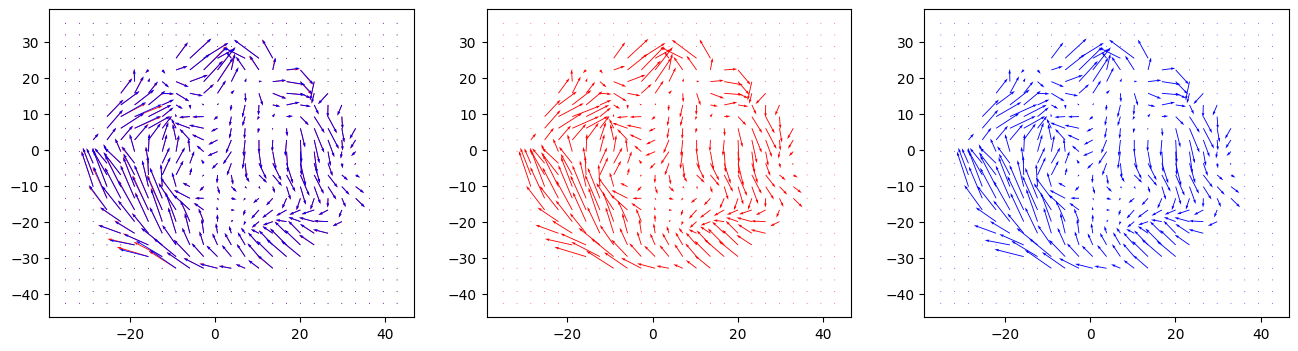

score:
0.9753006899482843
1


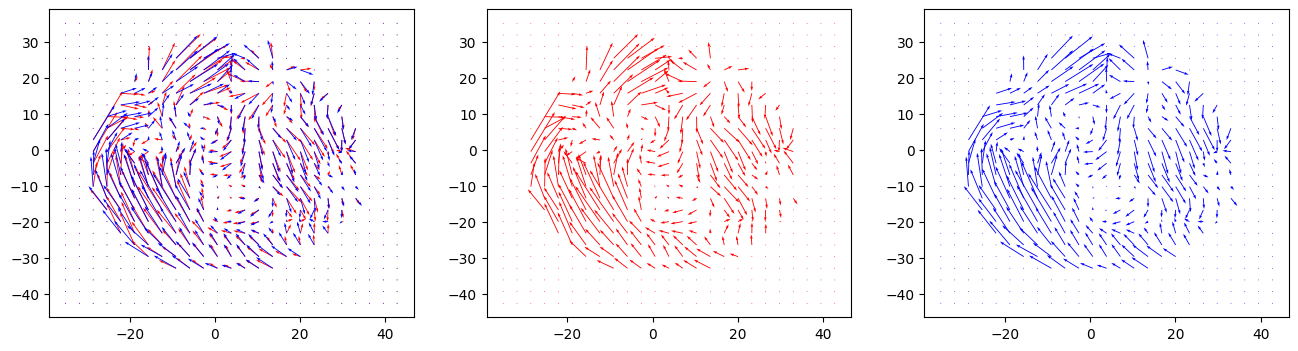

score:
0.27843206524534136
2


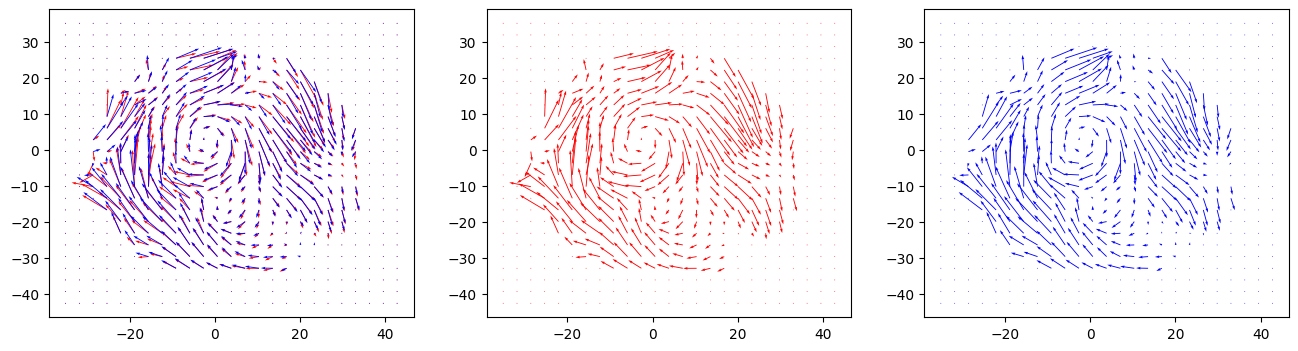

score:
0.6857042394354852
3


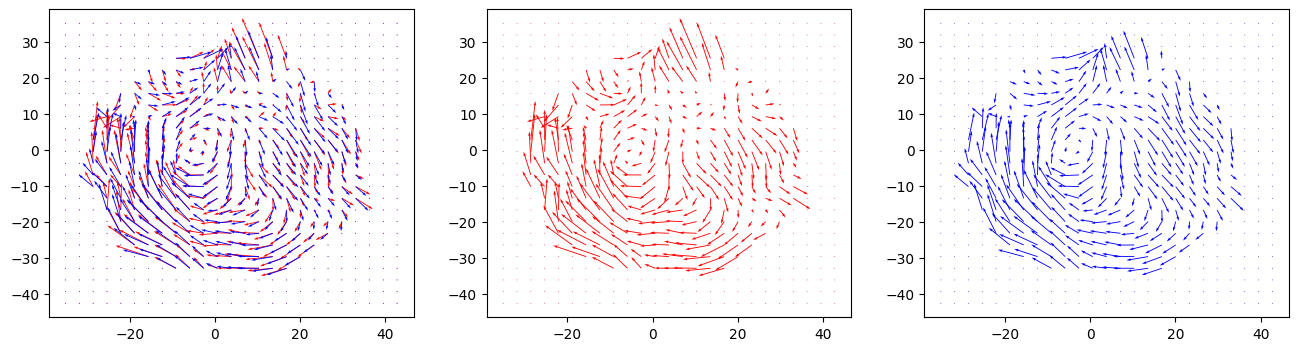

score:
-1.8922577987638731
4


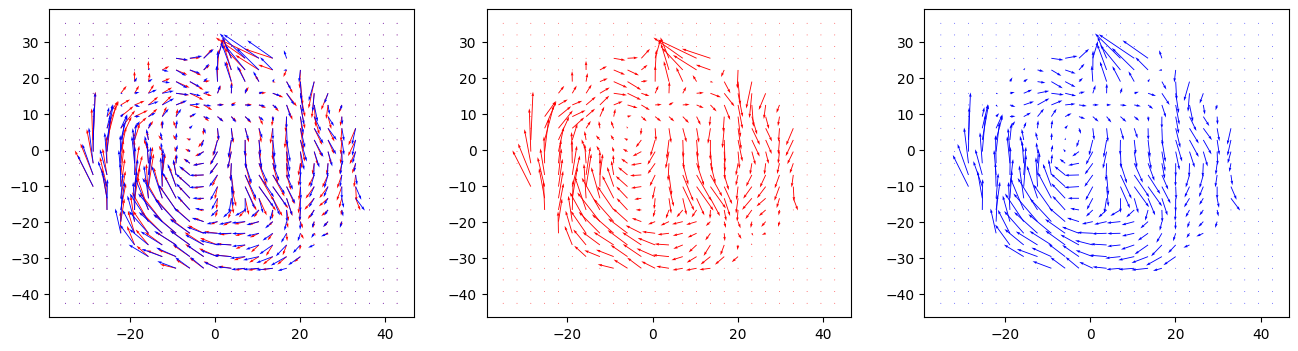

score:
0.6066963925454909
5


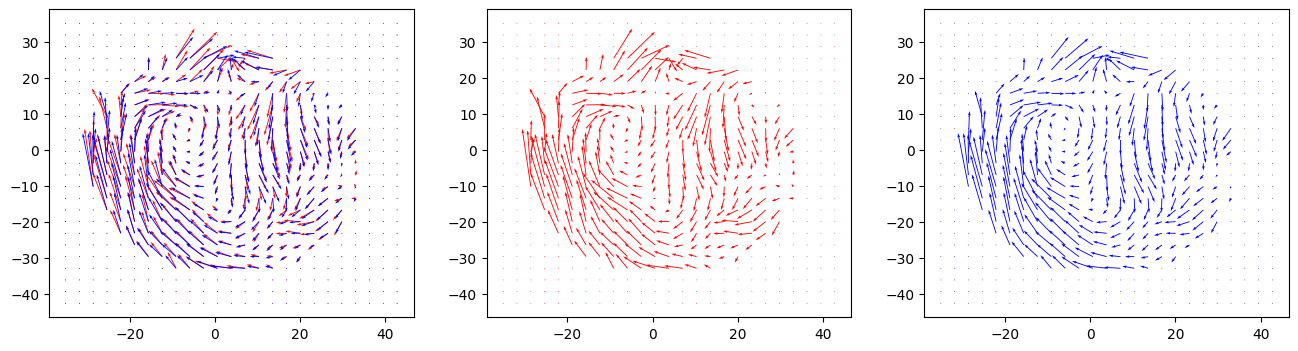

score:
0.6755469114008228
6


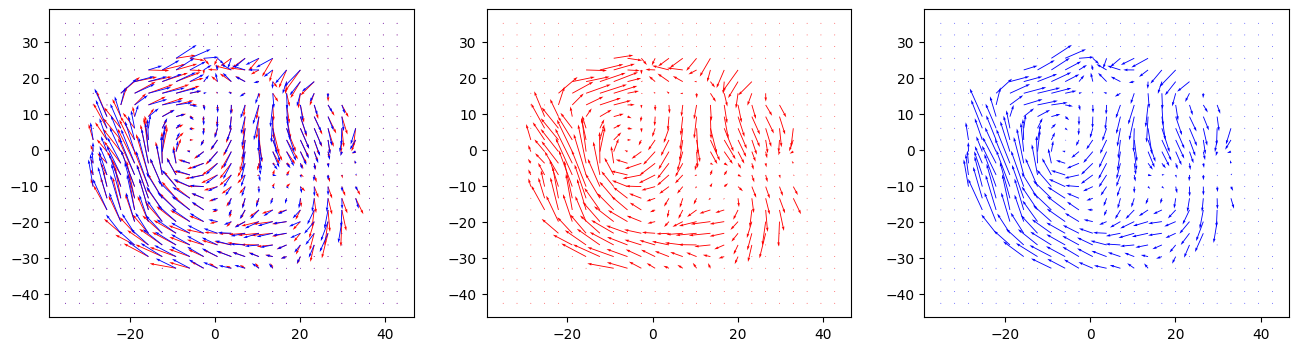

score:
0.6200633718156894
7


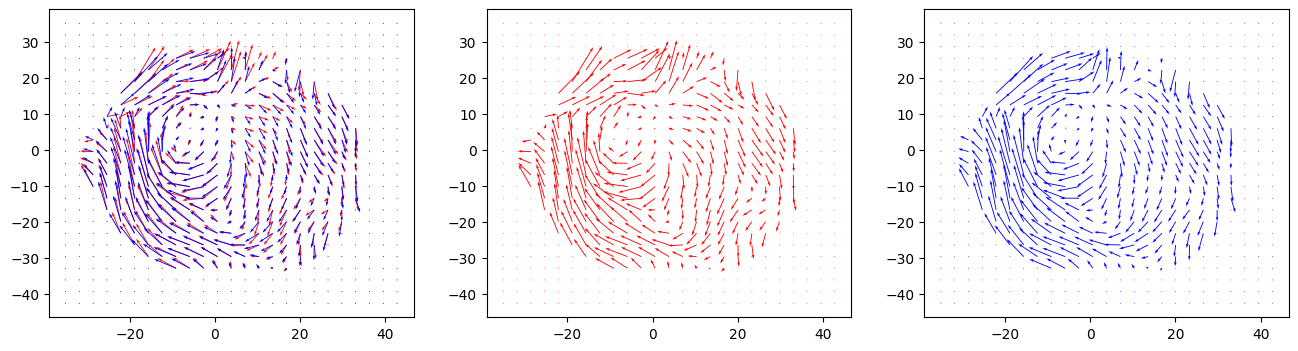

score:
0.6978059972060985
8


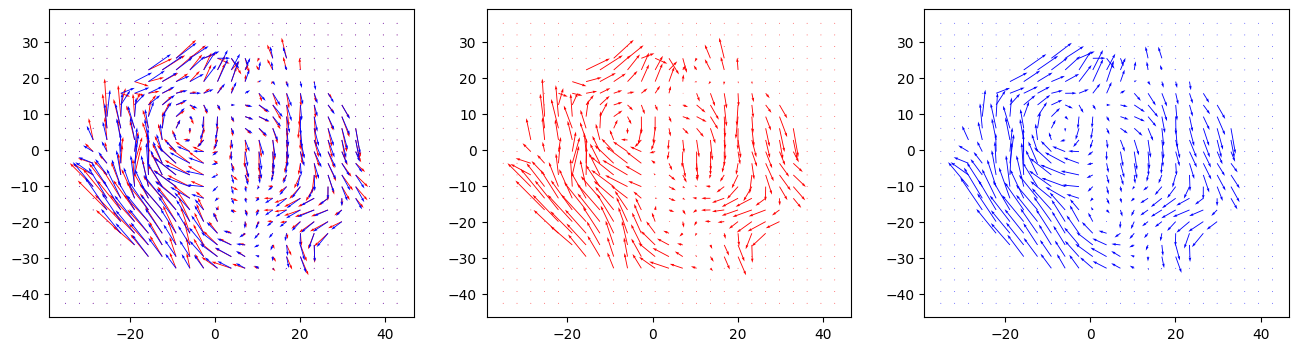

score:
0.4179923621638204
9


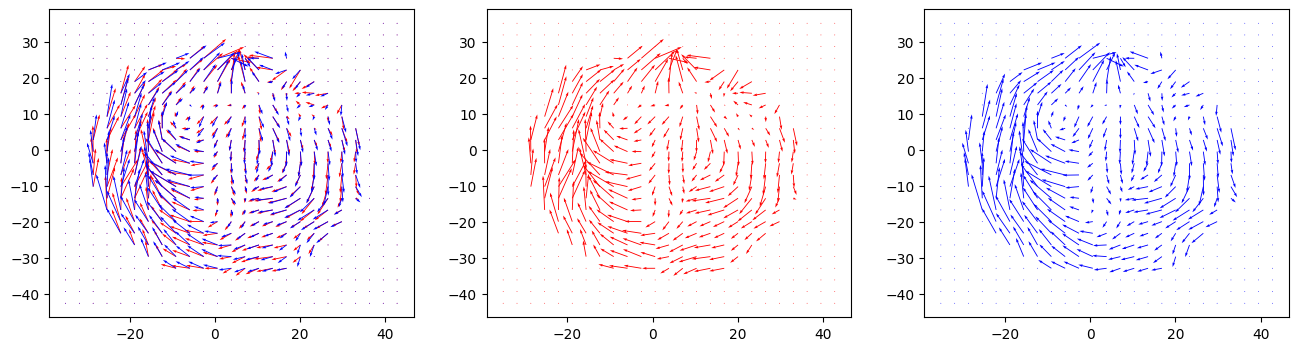

score:
0.2146279346071349
10


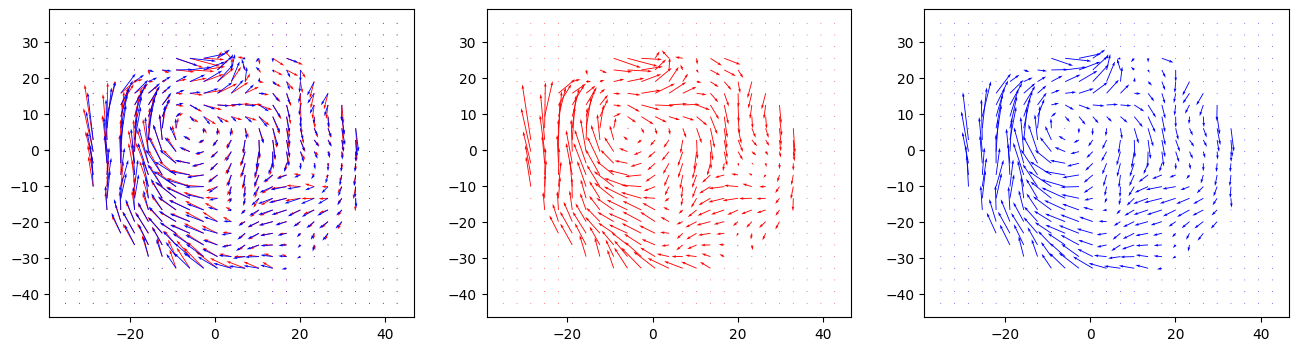

score:
0.6340682304190266
11


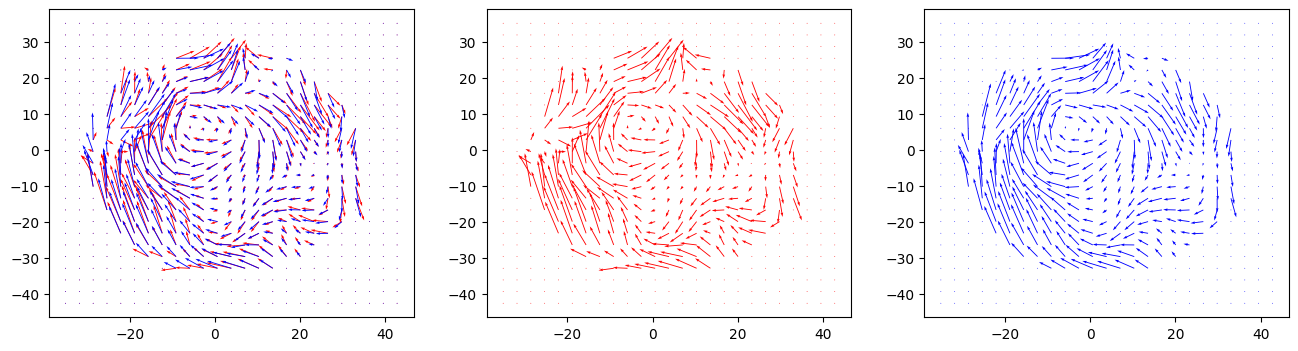

score:
0.2074107194947388
12


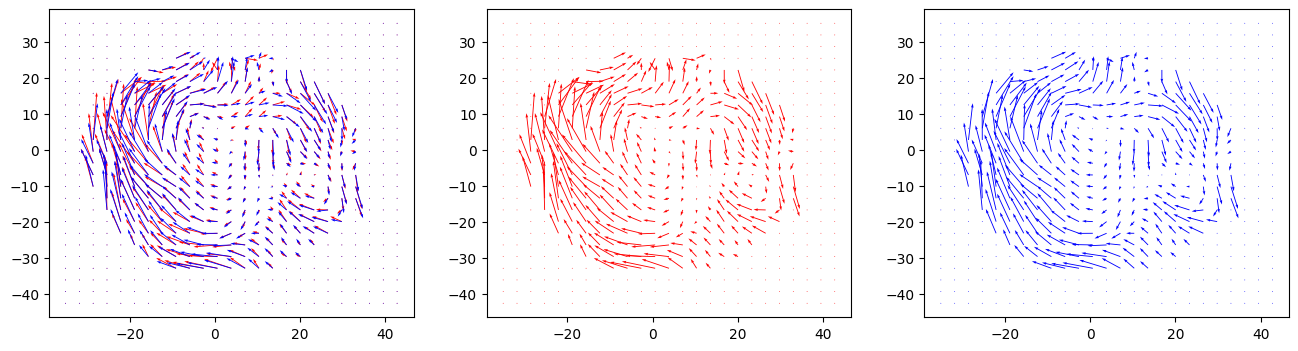

score:
0.5789713832436579
13


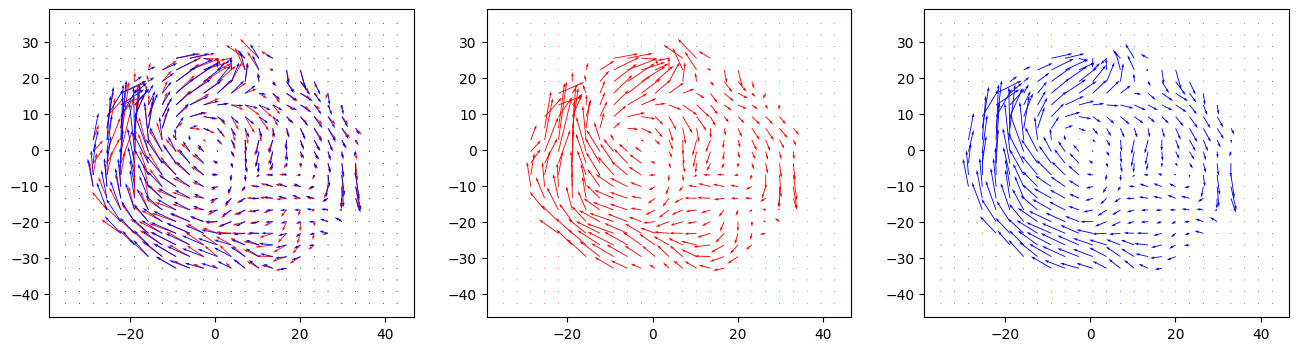

score:
0.3217004297752309
14


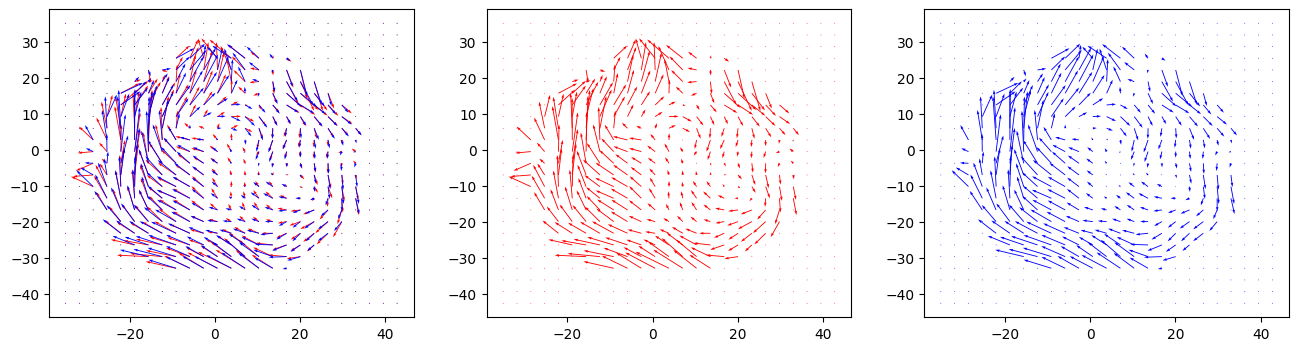

score:
0.6075312613092695
15


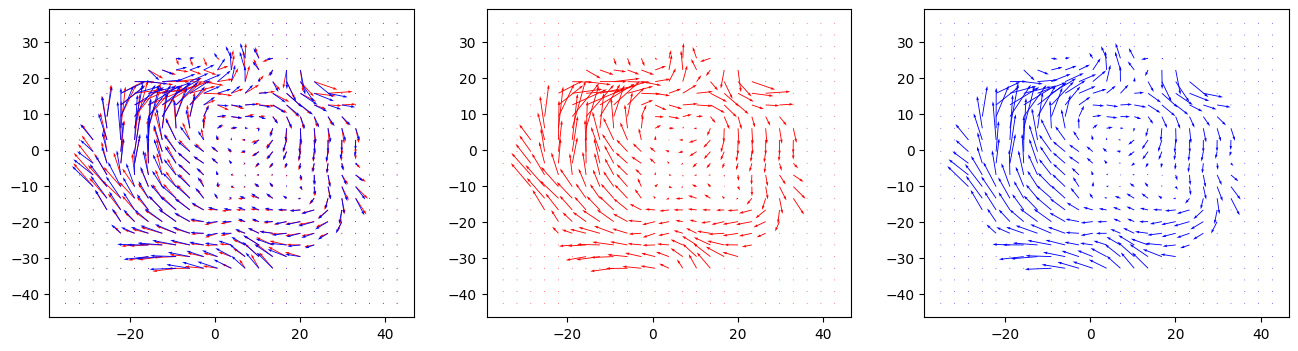

score:
0.6106133446392881
16


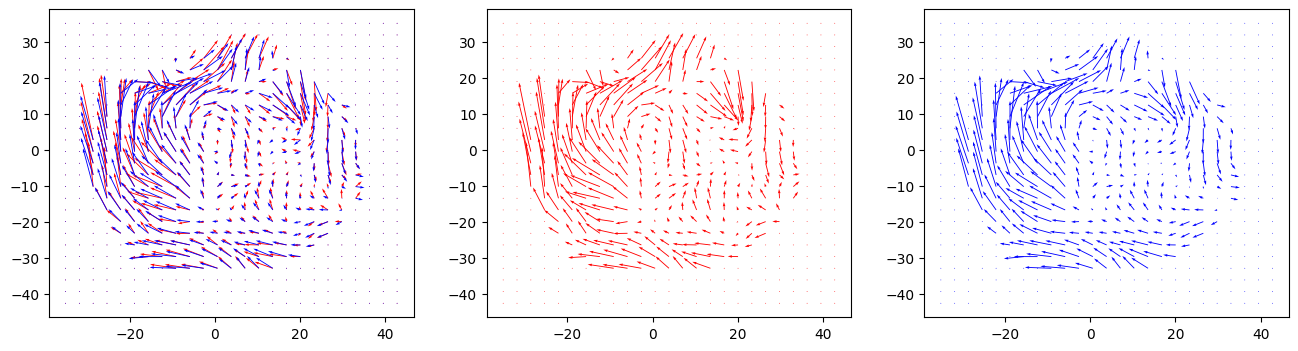

score:
0.5615751932458083
17


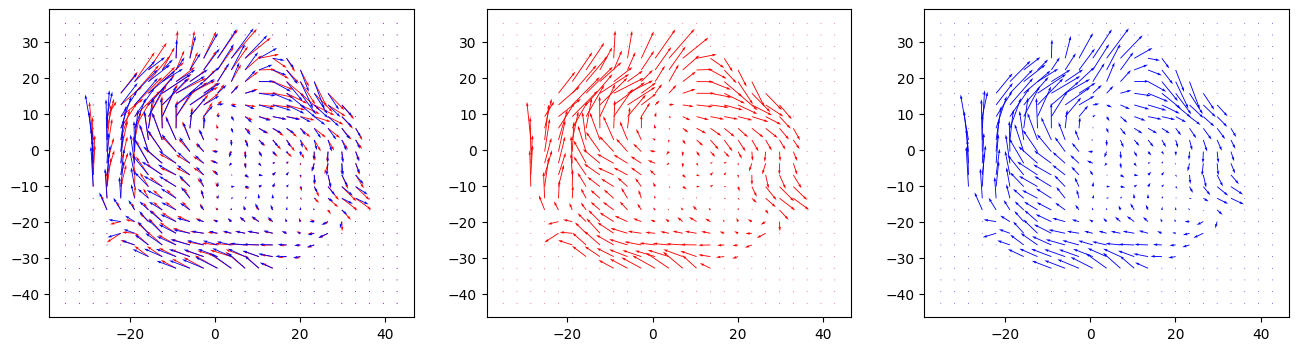

score:
0.6237075103796216
18


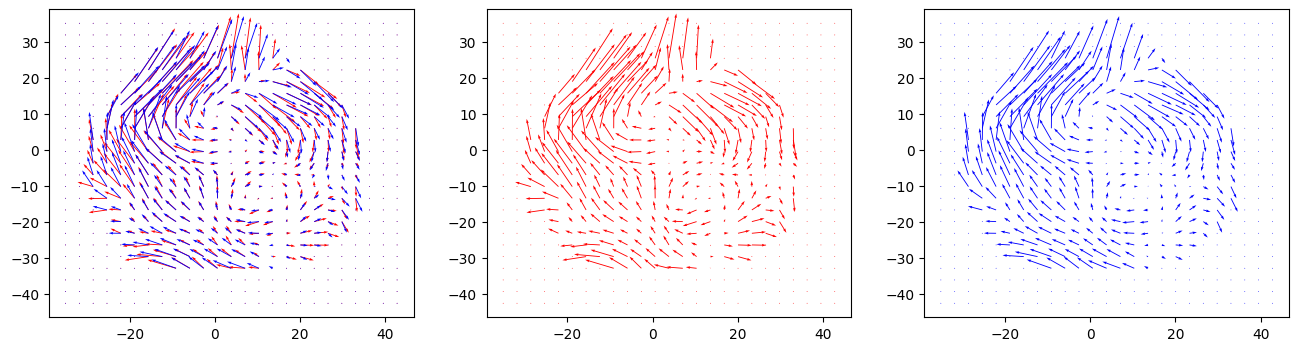

score:
-1.3448885282385494
19


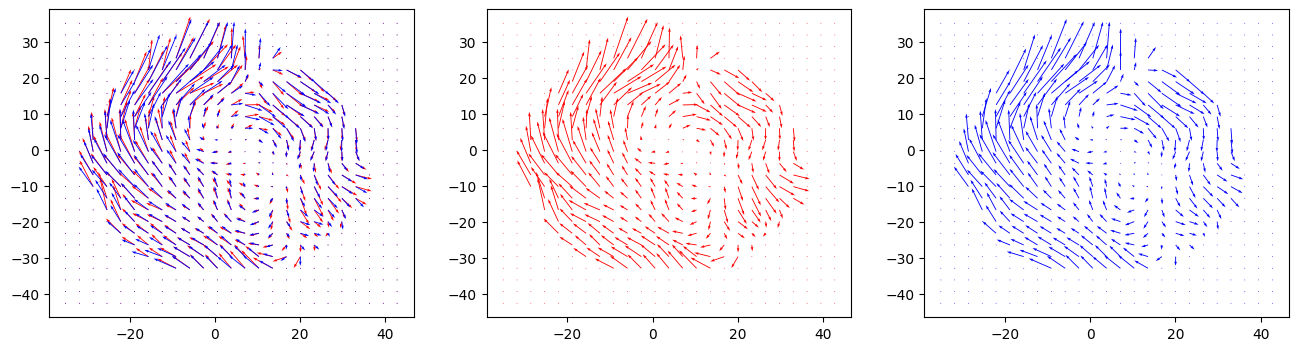

score:
0.7442713631024875
20


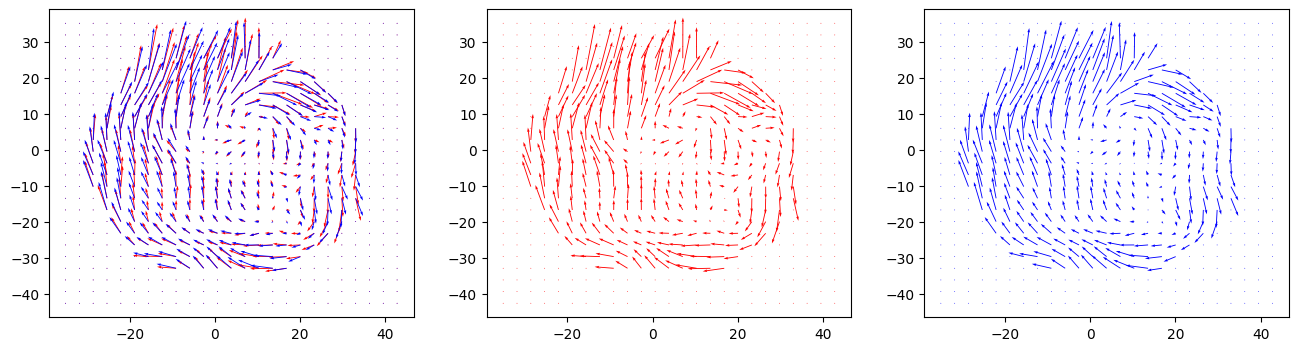

score:
-0.0709723646870473
21


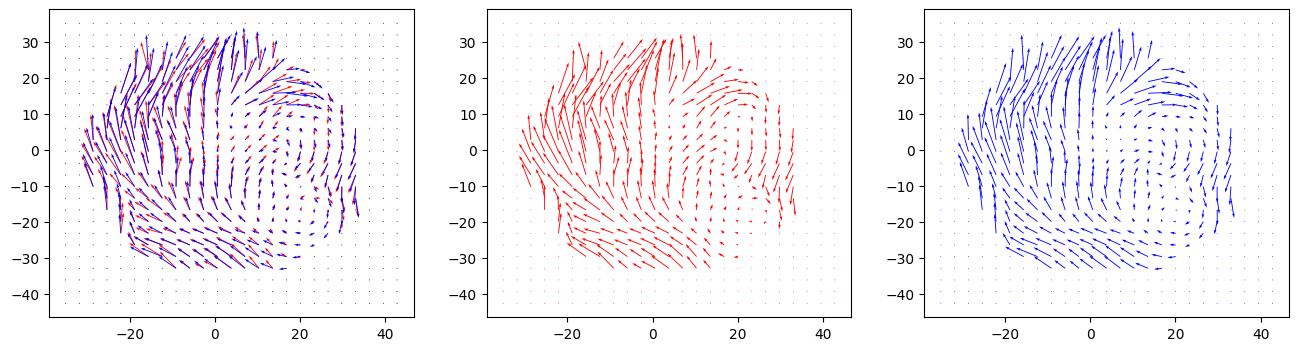

score:
0.42419369669687
22


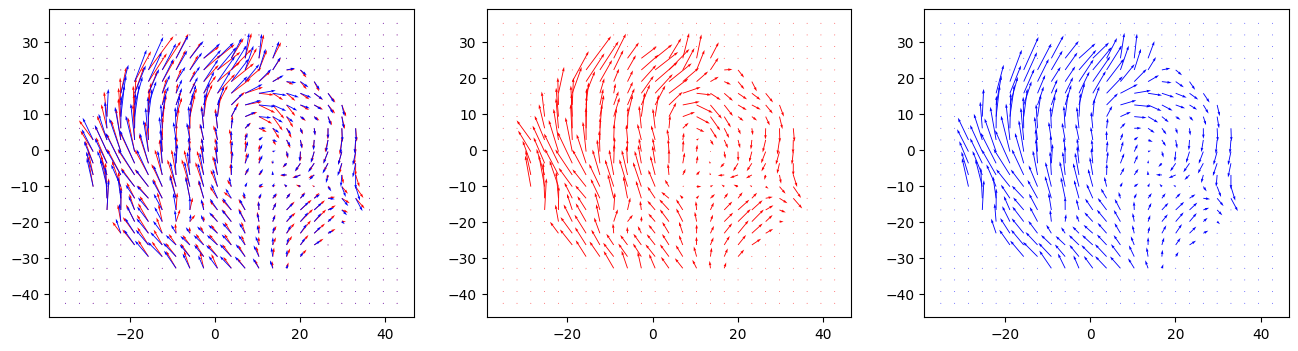

score:
0.5658561038486651
23


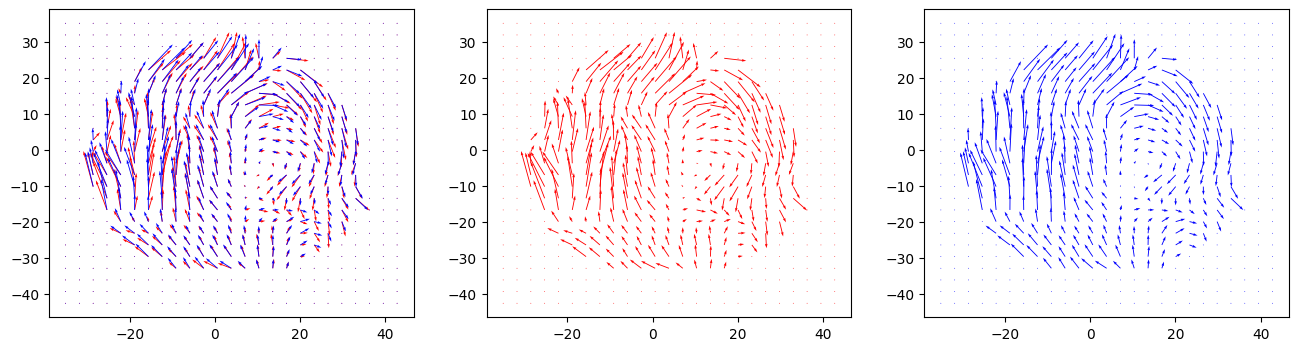

score:
0.750380112311642
24


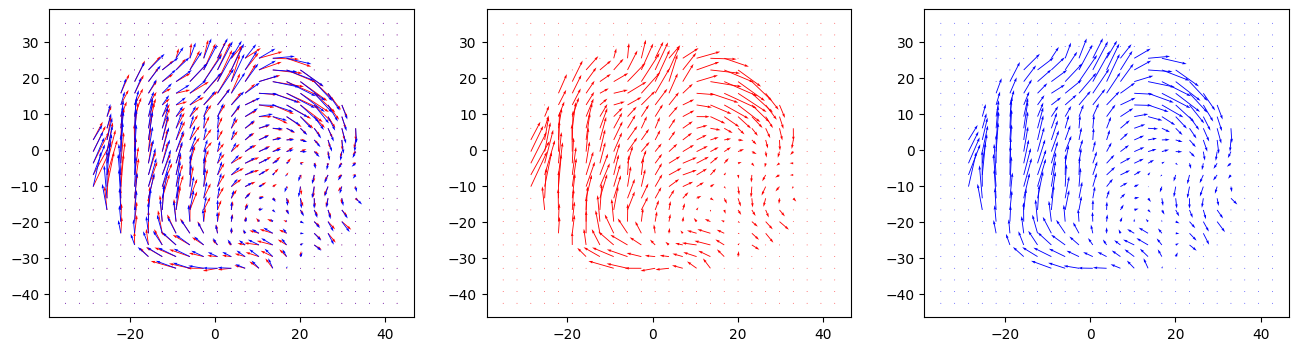

score:
0.6564632105703109
25


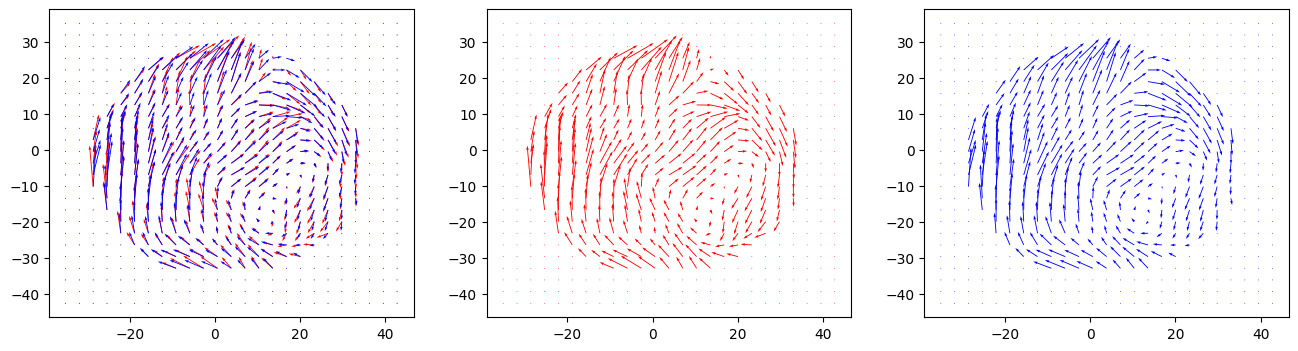

score:
0.7324743331093582
26


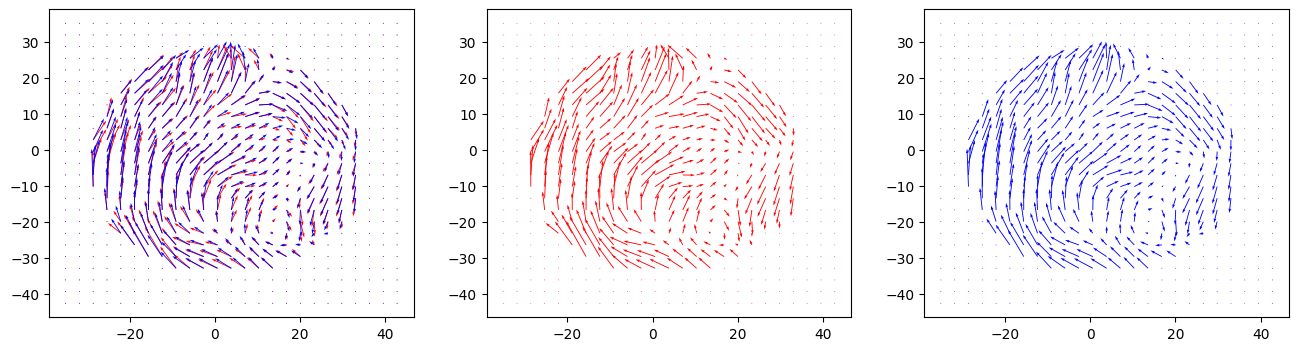

score:
0.7150625173364277
27


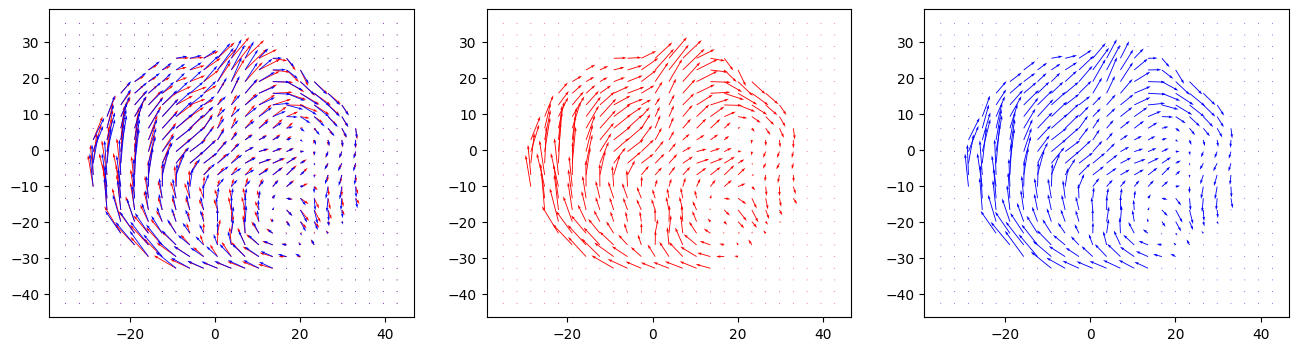

score:
0.6223231217894091
28


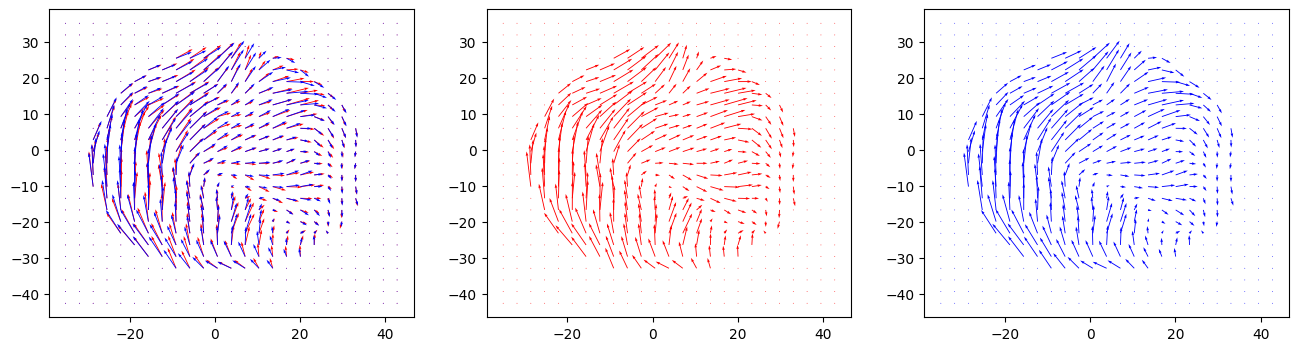

score:
0.6724677687167423
29


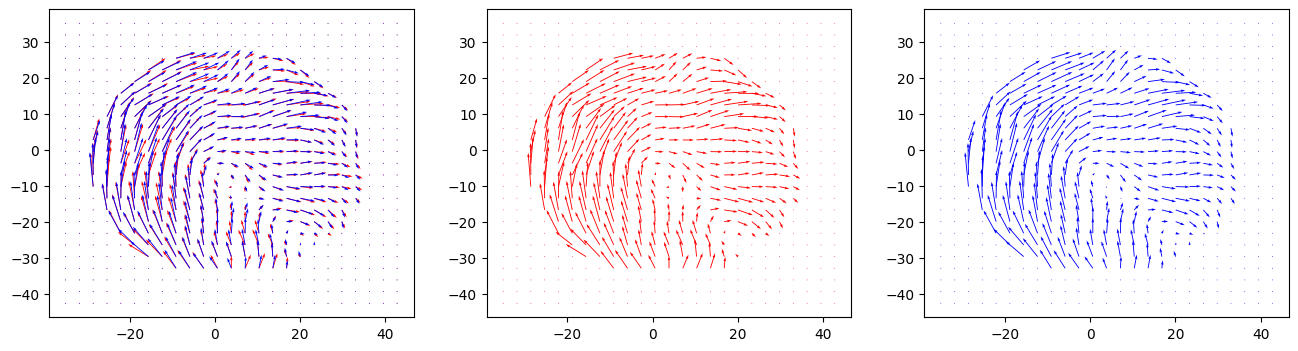

score:
0.3002541554731426
30


IndexError: index 90 is out of bounds for axis 2 with size 88

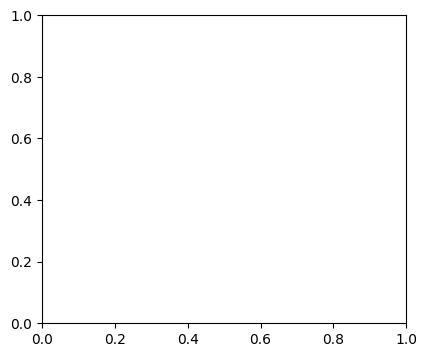

In [10]:
for i in range(40):
    print(i)
    j=i*3
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_train[:,:,j,0],v_train[:,:,j,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b')
    plt.subplot(1, 3, 2)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_train[:,:,j,0],v_train[:,:,j,1],color='r')
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 3)
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b')
    plt.show()
    testscore(pltpredict[:,:,j,],v_train[:,:,j,:])